# CNN Tumor Detection

## Problem Description
The goal of this project is to build a model that helps identify tumorous cells in pathology scans. Below there are two approaches, one using transfer learning (EfficientNetB0), and one building a small CNN from scratch.

## Dataset
The dataset contains 96x96 tif images of the scans. Additionally, there is a CSV file containing the image names and whether or not they contain cancerous tumors (0 or 1).

## Goal
The goal is to try an identify whether or not the scan contains tumors. 

### Notebook Usage
The best approach would be to read through the notebook and not try to execute the code, as it takes some time and money.

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.layers import BatchNormalization, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.metrics import AUC
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation
from sklearn.model_selection import train_test_split
import tensorflow_io as tfio

import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

2025-05-23 14:45:33.836710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748011534.263484      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748011534.386148      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_uti

In [3]:
import os, json, pathlib, stat

os.makedirs('/root/.kaggle', exist_ok=True)
json.dump(
    {"username": "USER_NAME", "key": "USER_KEY"}, # Removed personal information
    open('/root/.kaggle/kaggle.json', 'w')
)
pathlib.Path('/root/.kaggle/kaggle.json').chmod(0o600)
os.environ['KAGGLE_USERNAME'] = "USER_NAME"
os.environ['KAGGLE_KEY']     = "USERKEY"

In [6]:
!kaggle competitions download -c histopathologic-cancer-detection -p /kaggle/working

In [7]:
os.listdir('/kaggle/working/')

['.virtual_documents', 'histopathologic-cancer-detection.zip']

In [8]:
!unzip -q /kaggle/working/histopathologic-cancer-detection.zip -d /kaggle/working/data/

In [9]:
os.listdir('/kaggle/working/data')

['train', 'test', 'train_labels.csv', 'sample_submission.csv']

In [10]:
TRAIN_DIR='/kaggle/working/data/train/'
TEST_DIR='/kaggle/working/data/test/'
TRAIN_LABELS='/kaggle/working/data/train_labels.csv'

In [11]:
print(len(os.listdir(TRAIN_DIR)))
print(len(os.listdir(TEST_DIR)))

220025
57458


In [13]:
df_data = pd.read_csv(TRAIN_LABELS)

# removing images that have caused issues
df_data = df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']
df_data = df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']


print(df_data.shape)

(220023, 2)


## EDA
Below we'll:
- Identify and visualize class balance
- Display random scans from each class
- Randomly sample 20,000 scans for training
  - Retaining the same 60/40 class distribution
- Analyze and visualize Pixel distributions regarding channels and brightness

In [14]:
df_data['label'].value_counts()

label
0    130907
1     89116
Name: count, dtype: int64

Text(0.5, 1.0, 'Class balance (train set)')

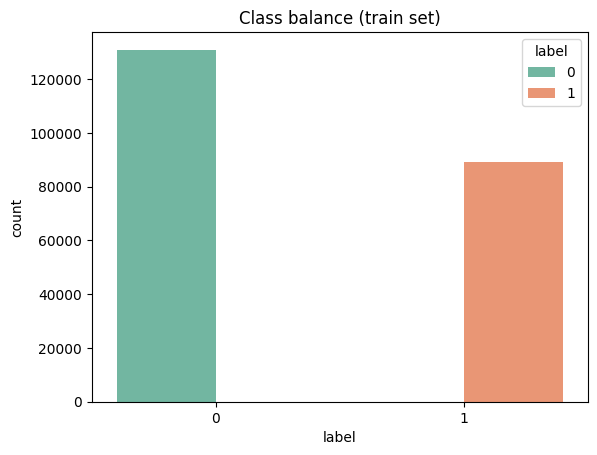

In [15]:
sns.countplot(
    x="label", 
    hue="label",
    data=df_data,
    palette="Set2"
)
plt.title('Class balance (train set)')

# The chart below shows about a 60/40 split in the data

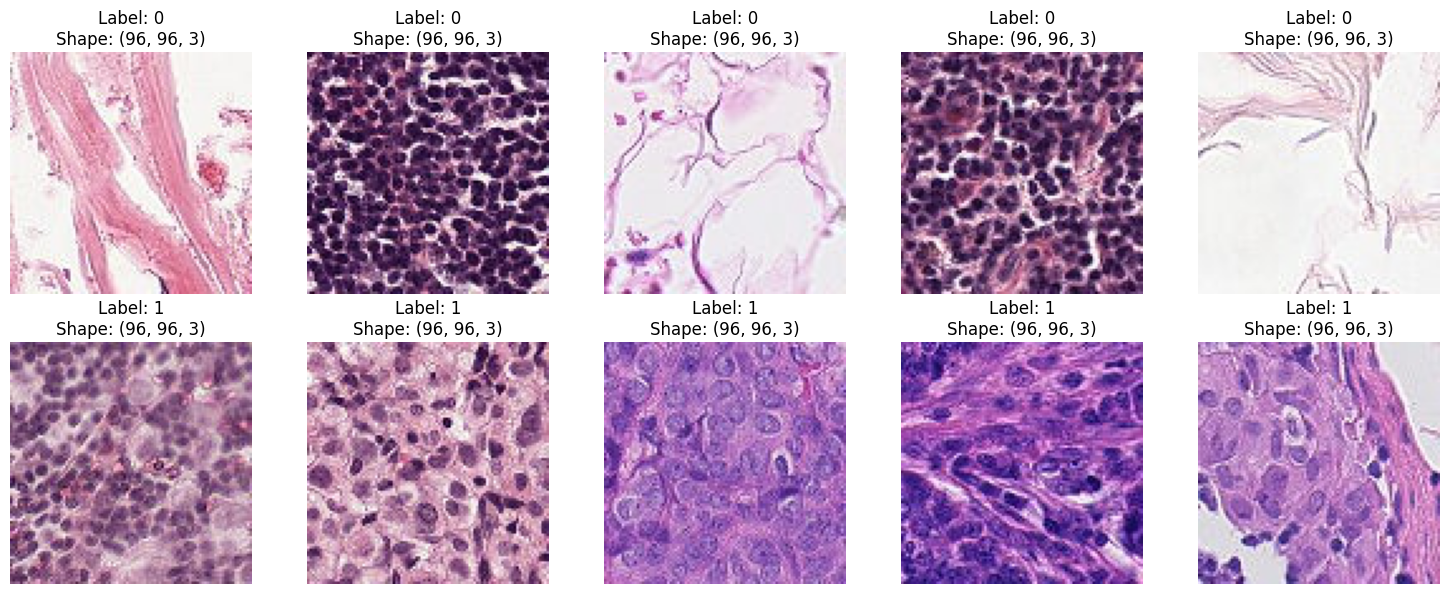

In [16]:
def show_random_images_per_class(df, train_dir, n=5):
    fig, axes = plt.subplots(2, n, figsize=(3*n, 6))
    for label in [0, 1]:
        df_class = df[df['label'] == label].sample(n, random_state=42)
        for i, (_, row) in enumerate(df_class.iterrows()):
            img_path = f"{train_dir}{row['id']}.tif"
            img = Image.open(img_path)
            ax = axes[label, i]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"Label: {label}\nShape: {np.array(img).shape}")
    plt.tight_layout()
    plt.show()

show_random_images_per_class(df_data, TRAIN_DIR, n=5)

# Showing 5 random images per class

In [17]:
# Creating a DataFrame with 20,000 randome images, while maintaining the same 60/40 distribution

print("--- Show top 5 rows in the dataset: ---")
print(df_data.head())

# Lets take a random sample of class 1
df_class_1 = df_data[df_data['label'] == 1].sample(8000, random_state=42)
print("\n")
print("--- Five Random Class 1 Rows: ---")
print(df_class_1.head())

# Lets take a random sample of class 0
df_class_0 = df_data[df_data['label'] == 0].sample(12000, random_state=42)
print("\n")
print("--- Five Random Class 0 Rows: ---")
print(df_class_0.head())

# Create a new dataframe with the sampled data and shuffle it
df_sampled = pd.concat([df_class_1, df_class_0])
df_sampled = df_sampled.sample(frac=1, random_state=42)
print("\n")
print("--- Five Random Shuffled Rows: ---")
print(df_sampled.head())

--- Show top 5 rows in the dataset: ---
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


--- Five Random Class 1 Rows: ---
                                              id  label
200708  a9f7f612736ebf2fb47cd83ce0c368d3a480aeb2      1
84165   74101e990af2a82735dd4f5f8ba37291f847a5db      1
53339   9d746ed4a129ea8ed50bc2f30b1912a7a76764a5      1
176918  34ccaaed225f6dd7096f60f968f7bb815ab6ace1      1
204440  bb1818ecb807b052d5838dc2c0aa1a117e02f26c      1


--- Five Random Class 0 Rows: ---
                                              id  label
121450  941ffe73059292e0effd4e81ca9363c117afc2f4      0
38268   43b6acadb31161c9281460efa3fad0b992a92837      0
158082  e23f232a132a818efaf94ba0679147f4fe4c20ca      0
154806  1d6908b8f5fc13

In [18]:
# The goal was to keep the ratio about 60/40
print(df_sampled['label'].value_counts())
print(df_sampled.shape)
print(f"Total rows: {len(df_sampled)}")

label
0    12000
1     8000
Name: count, dtype: int64
(20000, 2)
Total rows: 20000


In [19]:
# Verify 500 images are the same size, along with three channels
count = 0
for i in range(500):
    img_path = f"{TRAIN_DIR}{df_sampled.iloc[i]['id']}.tif"
    img = Image.open(img_path)
    assert img.size == (96, 96)
    assert img.mode == 'RGB'
    count += 1
print(f"{count} images validated")

500 images validated


Text(0.5, 1.0, 'Class balance (train set)')

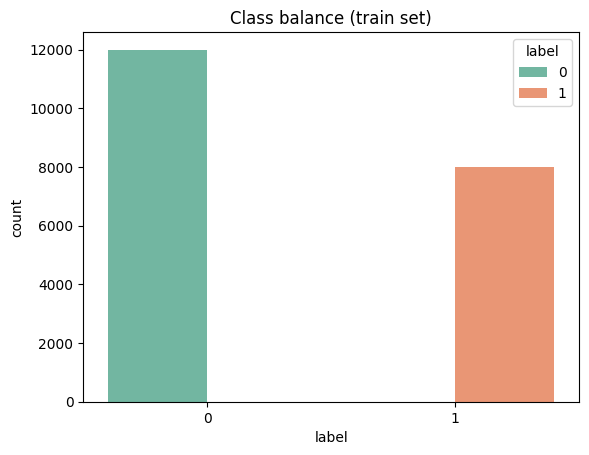

In [20]:
sns.countplot(
    x="label", 
    hue="label",
    data=df_sampled,
    palette="Set2", 
)
plt.title('Class balance (train set)')

# Attempting to keep the 60/40 split in the data

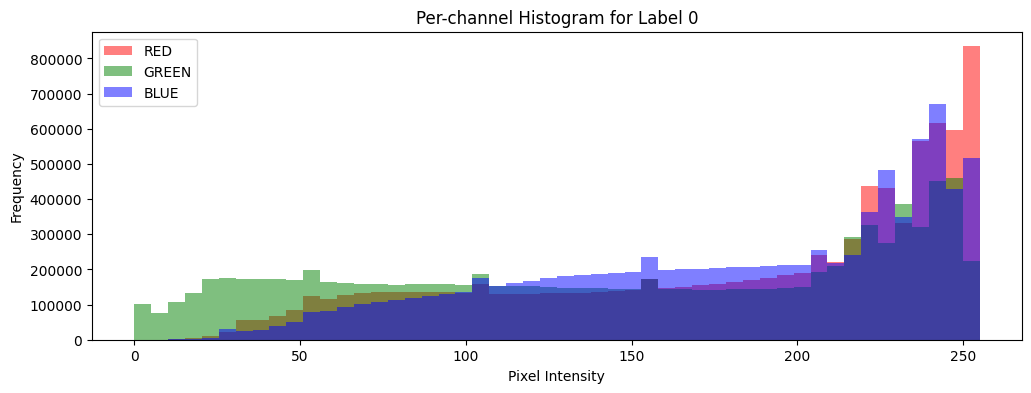

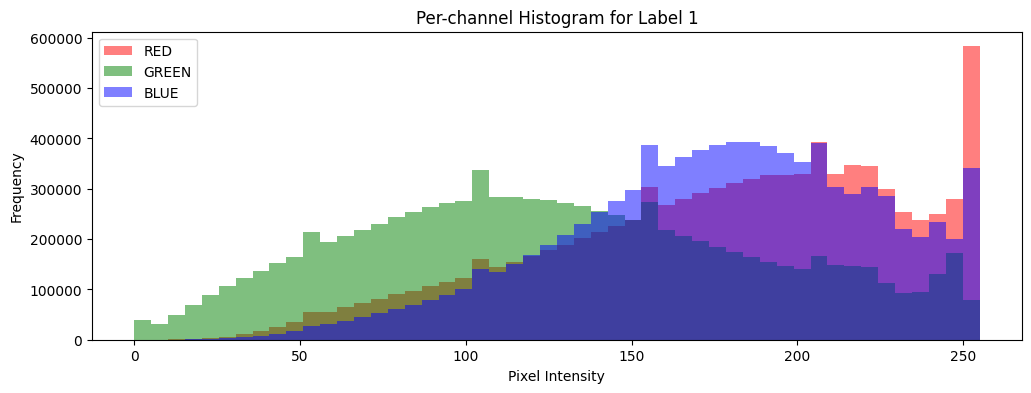

                                         id  label      r_mean      g_mean  \
0  503ce830d24cf24ed0552153e41144de0003074c      0  109.701497   62.562609   
1  884d8a7c5de3ce4d33e1c02c7fb5cf272347842b      0  168.190538  127.564996   
2  eb8b63afebd360fe50846727dc5cb83e48c378bd      0  104.287326   54.768663   
3  93bda6a6e89229c81fdb25badb2871332c214587      0  216.702474  174.492730   
4  0942426756582d6e30ca4cae1fecccc6e3e0dd7f      0  229.901476  218.921658   

       b_mean  brightness  
0  158.980903  159.016927  
1  185.572591  187.071832  
2  151.782552  151.825087  
3  216.869900  221.646376  
4  221.862630  230.423828  


Text(0.5, 1.0, 'Brightness Histogram')

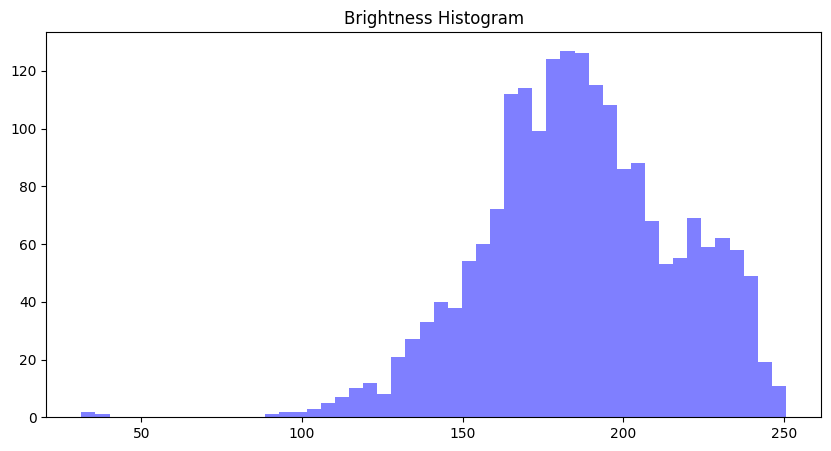

In [19]:
# Pixel Analysis:
# The goal is to understand the distribution of pixel intensities across different color channels
# And compare those intensities, brightness, and statistics between class 0 and 1 images

pixels_by_channel = {0: [[], [], []], 1: [[], [], []]}  # Storing Pixel intensity values
stats = [] # Stores mean and brightness information
sample_size = 1000

# These loops use the dataframe to find/open the associated inage for analysis
# and stores the information in the above dict/list
for label in [0, 1]:
    df_label = df_sampled[df_sampled['label'] == label].sample(n=sample_size, random_state=42)
    for img_id in df_label['id']:
        img_path = f"{TRAIN_DIR}{img_id}.tif"
        img_pil = Image.open(img_path)
        img = np.array(img_pil) 
        for c in range(3):  # R, G, B
            pixels_by_channel[label][c].extend(img[..., c].flatten())
        arr = np.array(img)
        r_mean = arr[..., 0].mean()
        g_mean = arr[..., 1].mean()
        b_mean = arr[..., 2].mean()
        # Brightness via HSV
        v = np.array(img_pil.convert('HSV').getchannel(2)).mean()
        stats.append({
            'id': img_id,
            'label': label,
            'r_mean': r_mean,
            'g_mean': g_mean,
            'b_mean': b_mean,
            'brightness': v
        })
        
# Plot histograms
colors = ['red', 'green', 'blue']
for label in [0, 1]:
    plt.figure(figsize=(12, 4))
    for c, color in enumerate(colors):
        plt.hist(pixels_by_channel[label][c], bins=50, color=color, alpha=0.5, label=f'{color.upper()}')
    plt.title(f'Per-channel Histogram for Label {label}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
# Create a dataframe from the stats
df_stats = pd.DataFrame(stats)
print(df_stats.head())
# Plot the brightness histogram
plt.figure(figsize=(10, 5))
plt.hist(df_stats['brightness'], bins=50, color='blue', alpha=0.5)
plt.title('Brightness Histogram')

### EDA Results
- Pixel intensity for label 1 seems to be more distributed, with peaks around the max of 255.
- Pixel intensity for label 0 is less distributed, but also peaks around the max.

## Model Building
1. The fist Model will be a partial transfer learning approach. We'll attempt to use EfficientNetB0, followed by a dropoout layer.
   - There were a couple of dense layers after the transfer learning model, but there was too much over-fitting
   - The best approach ended up being to un-freeze layers at the end of the transfer learning model
2. The second model will be a CNN made up of 6 Conv layers and 3 dense layers

In [68]:
from tensorflow.keras.applications import EfficientNetB0

ENB0_model = EfficientNetB0(input_shape=(96, 96, 3), weights='imagenet', include_top=False)

# Freeze all layers except last ~70 layers
for layer in ENB0_model.layers[:-70]:
    layer.trainable = False

In [69]:
ENB0_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 96, 96, 3)      │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 96, 96, 3)      │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 97, 97, 3)      │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 3,062,332 (11.68 MB)

 Non-trainable params: 987,239 (3.77 MB)

In [70]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.3),
])

In [71]:
# Transfer Learning model
tl_model = Sequential()
tl_model.add(data_augmentation)
tl_model.add(ENB0_model)
tl_model.add(GlobalAveragePooling2D())

tl_model.add(Dropout(0.3))

tl_model.add(Dense(1, activation="sigmoid", dtype='float32', name="prediction"))

tl_model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=['accuracy', AUC()])

tl_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_22 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_13          │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prediction (Dense)                   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 3,062,332 (11.68 MB)

 Non-trainable params: 987,239 (3.77 MB)

In [41]:
tl_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prediction (Dense)                   │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 2,672,064 (10.19 MB)

 Non-trainable params: 1,377,507 (5.25 MB)

In [81]:
# Adjusting data Augmentation for this model (CNN), as there is some initial overfitting
cn_data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.3),
])

In [82]:
# CNN Model
cn_model = Sequential([
    cn_data_augmentation,
    Conv2D(32, 3, padding='same', activation='relu', input_shape=(96,96,3)),
    BatchNormalization(),
    Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    GlobalAveragePooling2D(),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid', name='prediction')
])

cn_model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=['accuracy', AUC()])

cn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_24 (Sequential)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_14          │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ ?                           │     0 (unbuil

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [83]:
# Training and Validation splits
train_df, val_df = train_test_split(
    df_sampled,
    test_size=0.2,         # 20% for validation
    stratify=df_sampled['label'],  # preserves class balance
    random_state=42
)

print(train_df['label'].value_counts())
print(val_df['label'].value_counts())

label
0    9600
1    6400
Name: count, dtype: int64
label
0    2400
1    1600
Name: count, dtype: int64


In [28]:
# Retrieve images listed in the dataframes and creates the datasets

def df_to_dataset(df, batch_size=32):
    paths = df['id'].values
    labels = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load_img_py(img_id_tensor): # Renamed variable to indicate it's a tensor
        # This function runs in Python, not directly in the TF graph
        # Convert the tensor back to a Python string
        img_id = img_id_tensor.numpy().decode('utf-8')
        img_path_str = TRAIN_DIR + img_id + ".tif"
        img_pil = Image.open(img_path_str)
        img_np = np.array(img_pil)
        return img_np

    def _load_img(path, label):
        # Use tf.py_function to wrap the Python loading function
        # The output types and shape must be specified
        img = tf.py_function(
            func=_load_img_py,
            inp=[path], # Pass the image ID tensor to the Python function
            Tout=tf.uint8 # Expected output type from Image.open + np.array
        )

        img.set_shape([96, 96, 3]) # Set the shape explicitly as py_function loses shape info
        img = tf.cast(img, tf.float32) # Ensure data type is float32 before normalization
        img = img / 255.0 # Normalize pixel values
        # label = tf.one_hot(label, 2)
        label = tf.cast(label, tf.float32)
        return img, label

    ds = ds.map(_load_img, num_parallel_calls=tf.data.AUTOTUNE)
    # ds = ds.cache()
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [84]:
BATCH_SIZE = 32

# Create datasets
train_ds = df_to_dataset(train_df, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(val_df, batch_size=BATCH_SIZE)

---
### Transfer Learning Model Implementation

In [74]:
tl_hist = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10


E0000 00:00:1748015602.599073      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_23_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 90ms/step - accuracy: 0.6022 - auc_11: 0.6187 - loss: 0.6769 - val_accuracy: 0.6055 - val_auc_11: 0.6513 - val_loss: 0.6453
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.6720 - auc_11: 0.7241 - loss: 0.5990 - val_accuracy: 0.7055 - val_auc_11: 0.7612 - val_loss: 0.5703
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.6900 - auc_11: 0.7455 - loss: 0.5812 - val_accuracy: 0.6308 - val_auc_11: 0.6976 - val_loss: 0.6567
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 85ms/step - accuracy: 0.7023 - auc_11: 0.7599 - loss: 0.5688 - val_accuracy: 0.7067 - val_auc_11: 0.7613 - val_loss: 0.6162
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.6975 - auc_11: 0.7626 - loss: 0.5670 - val_accuracy: 0.6305 - val_auc_11: 0.6917 - val_loss: 0.6853
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.7161 - auc_11: 0.7759 - loss: 0.5545 - val_accuracy: 0.7040 - val_auc_11: 0.7614 - val_loss: 0.5900
Epo

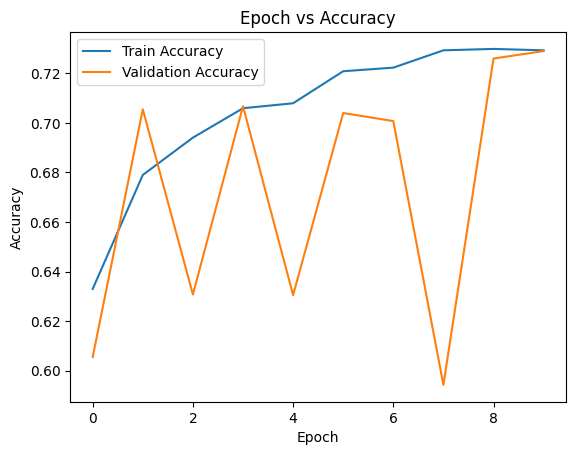

In [75]:
plt.plot(tl_hist.history['accuracy'], label='Train Accuracy')
plt.plot(tl_hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.show()

In [76]:
print(tl_hist.history.keys())

dict_keys(['accuracy', 'auc_11', 'loss', 'val_accuracy', 'val_auc_11', 'val_loss'])


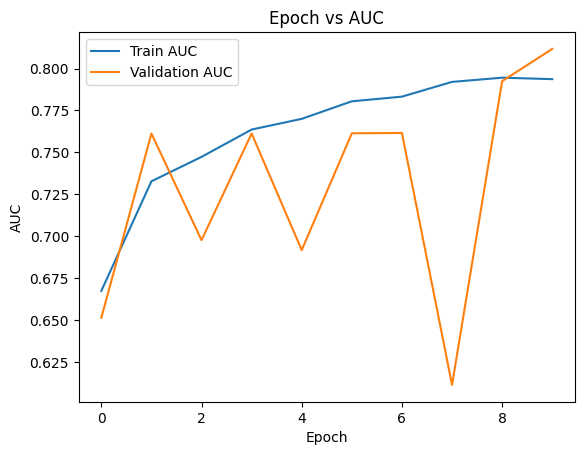

In [77]:
plt.plot(tl_hist.history['auc_11'], label='Train AUC')
plt.plot(tl_hist.history['val_auc_11'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Epoch vs AUC')
plt.legend()
plt.show()

### Transfer Learning Training/Validation Results
After constructing the model and adjusting hyperparameters several times, this model's validation and training accuracy began to hover around 70%.
Below are some of the changes that led to positive results
1. Adjusted Hyperparamers:
   - Un-froze the last 60 layers of the transfered model due to some initial overfitting
   - Used global average pooling instead of a flattening layer to reduce parameters and complexity
   - Used Batch size of 32
   - adjusted final dense layer to 128

---

### CNN Model Implementation

In [85]:
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

cn_hist = cn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 63s 106ms/step - accuracy: 0.7223 - auc_12: 0.7877 - loss: 0.6401 - val_accuracy: 0.6582 - val_auc_12: 0.6427 - val_loss: 1.0691
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.8063 - auc_12: 0.8753 - loss: 0.4614 - val_accuracy: 0.6877 - val_auc_12: 0.8121 - val_loss: 0.8641
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 105ms/step - accuracy: 0.8242 - auc_12: 0.8949 - loss: 0.4239 - val_accuracy: 0.6660 - val_auc_12: 0.7937 - val_loss: 1.0618
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.8308 - auc_12: 0.9027 - loss: 0.4078 - val_accuracy: 0.7663 - val_auc_12: 0.8824 - val_loss: 0.4987
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 105ms/step - accuracy: 0.8427 - auc_12: 0.9127 - loss: 0.3859 - val_accuracy: 0.8030 - val_auc_12: 0.9182 - val_loss: 0.4640
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 105ms/step - accuracy: 0.8488 - auc_12: 0.9209 - loss: 0.3675 - val_accuracy: 0.6945 - val_auc_12: 0.8490 - val

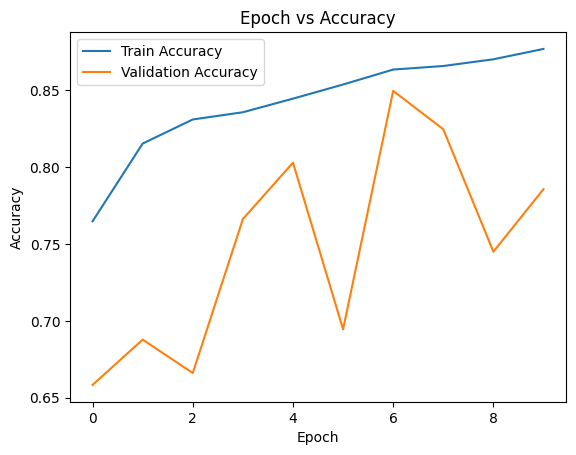

In [86]:
plt.plot(cn_hist.history['accuracy'], label='Train Accuracy')
plt.plot(cn_hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.show()

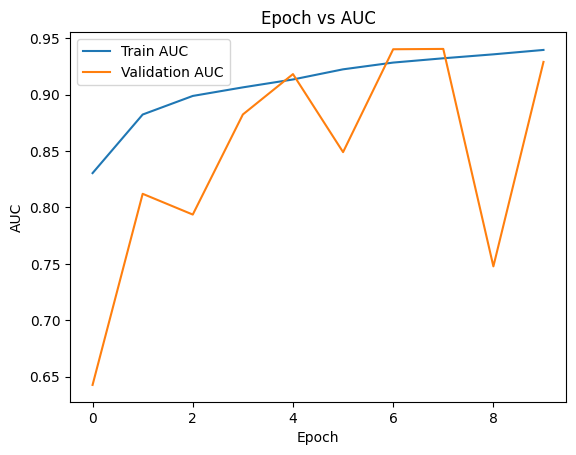

In [87]:
plt.plot(cn_hist.history['auc_12'], label='Train AUC')
plt.plot(cn_hist.history['val_auc_12'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Epoch vs AUC')
plt.legend()
plt.show()

---
### Predictions

I ended up using the CNN model, as it seems to generalize a bit better than the TL model. Additionally, training accuracy was better in both training and validation.

In [92]:
def test_ids_to_dataset(img_ids, batch_size=32, test_dir=None):
    """
    Creates a tf.data.Dataset for test images given a list of image IDs (without .tif extension).
    Args:
        img_ids: list of image IDs (strings, no .tif)
        batch_size: batch size for dataset
        test_dir: directory containing test images, ending with '/'
    Returns:
        tf.data.Dataset yielding batches of images (normalized float32, shape [96, 96, 3])
    """
    if test_dir is None:
        raise ValueError("test_dir must be specified")
    ds = tf.data.Dataset.from_tensor_slices(img_ids)

    def _load_img_py(img_id_tensor):
        img_id = img_id_tensor.numpy().decode('utf-8')
        img_path_str = test_dir + img_id + ".tif"
        img_pil = Image.open(img_path_str).resize((96, 96))
        img_np = np.array(img_pil)
        if img_np.ndim == 2:  # grayscale to RGB
            img_np = np.stack([img_np]*3, axis=-1)
        if img_np.shape[-1] == 4:  # RGBA to RGB
            img_np = img_np[..., :3]
        return img_np

    def _load_img(path):
        img = tf.py_function(
            func=_load_img_py,
            inp=[path],
            Tout=tf.uint8
        )
        img.set_shape([96, 96, 3])
        img = tf.cast(img, tf.float32) / 255.0
        return img

    ds = ds.map(_load_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [93]:
test_image_paths = glob.glob(os.path.join(TEST_DIR, '*.tif'))
test_ids = [os.path.splitext(os.path.basename(p))[0] for p in test_image_paths]

test_ds = test_ids_to_dataset(test_ids, batch_size=32, test_dir=TEST_DIR)

In [94]:
# run inference using transfered learning
preds = cn_model.predict(test_ds)
predicted_labels = (preds > 0.5).astype(int).flatten()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 108s 60ms/step


In [95]:
# Remove directory and .tif extension to get the id
ids = [os.path.splitext(os.path.basename(p))[0] for p in test_image_paths]

results_df = pd.DataFrame({'id': ids, 'label': predicted_labels})
results_df.to_csv('test_predictions.csv', index=False)